In [51]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import urllib.request
import matplotlib.pyplot as plt
import scipy.optimize as opt
import random
from nltk import ngrams, FreqDist
import nltk
import math
from numpy.random import multinomial
import numpy as np

In [52]:
text_url = r'http://www.gutenberg.org/files/11/11-0.txt'
data =  urllib.request.urlopen(text_url).read()


In [53]:
## Data variable encoding changed from bytes to string
data = data.decode('utf-8')

## Splitting the corpus into lines for tokenization
data = data.split('\r\n')

In [54]:
data = data[data.index('ALICE’S ADVENTURES IN WONDERLAND'):data.index('End of Project Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll')]

In [55]:
data = ' '.join(data)


In [56]:
corpus = sent_tokenize(data)

In [57]:
def lower(s):
    return s.lower()
data = data.strip()
corpus = sent_tokenize(data)
corpus = list(map(lower,corpus))
# print (len(corpus))

In [68]:
('<s>',) in unigrams

True

In [50]:
# word_corpus = list(map(RegexpTokenizer(str),corpus))
tokenizer = RegexpTokenizer(r'\w+')
word_corpus =[]

for i in corpus:
    word_corpus.append(tokenizer.tokenize(i))

for i in range(len(word_corpus)):
    word_corpus[i].insert(0,'<s>')
    word_corpus[i].append('</s>')


random.shuffle(corpus)    
#print (corpus)
train = corpus[:int(0.8*len(corpus))]
test = corpus[int(0.8*len(corpus)):]

In [61]:
unigrams = []
bigrams =[]
trigrams=[]

for i in word_corpus:
    unigrams = unigrams + list(ngrams(i,1))
    bigrams = bigrams + list(ngrams(i,2))
    trigrams = trigrams + list(ngrams(i,3))


In [70]:
uni_freq = nltk.FreqDist(unigrams)
bi_freq = nltk.FreqDist(bigrams)
tri_freq = nltk.FreqDist(trigrams)

vocab = len(uni_freq.keys())

In [64]:
tot_uni_count=len(unigrams)
tot_bi_count=len(bigrams)
tot_tri_count=len(trigrams)

mle_uni ={}
mle_bi ={}
mle_tri ={}

for i in uni_freq:
    mle_uni[i] = uni_freq[i]/tot_uni_count
for i in bi_freq:
    #print(i)
    uni = ('%s'%(i[1]),)
    #print(uni)
    mle_bi[i] = bi_freq[i]/uni_freq[uni]
for i in tri_freq:
    bi = ('%s'%(i[0]), '%s'%(i[1]))
    #print(bi)
    mle_tri[i] = tri_freq[i]/bi_freq[bi]
    

In [145]:
print('====== Unigram MLE ======')
test_unigrams=[('the',), ('and',), ('to',), ('a',), ('it',)]
for i in test_unigrams:
    print('MLE for %s unigram is = %.3f'%(i,mle_uni[i]))

print('\n====== Bigram MLE ======')
test_bigrams = [('said', 'the'), ('of', 'the'), ('said', 'alice'), ('in', 'a'), ('and', 'the')]
for i in test_bigrams:
    print('MLE for %s bigram is = %.3f'%(i,mle_bi[i]))

print('\n====== Trigram MLE ======')
test_tri = [('the', 'mock', 'turtle'), ('the', 'march', 'hare'), ('i', 'don', 't'), ('said', 'the', 'king'), ('said', 'the', 'hatter')]
for i in test_tri:
    print('MLE for %s triigram is = %.3f'%(i,mle_tri[i]))



====== Unigram MLE ======
MLE for ('the',) unigram is = 0.056
MLE for ('and',) unigram is = 0.030
MLE for ('to',) unigram is = 0.025
MLE for ('a',) unigram is = 0.022
MLE for ('it',) unigram is = 0.020

====== Bigram MLE ======
MLE for ('said', 'the') bigram is = 0.127
MLE for ('of', 'the') bigram is = 0.081
MLE for ('said', 'alice') bigram is = 0.291
MLE for ('in', 'a') bigram is = 0.153
MLE for ('and', 'the') bigram is = 0.050

====== Trigram MLE ======
MLE for ('the', 'mock', 'turtle') triigram is = 1.000
MLE for ('the', 'march', 'hare') triigram is = 1.000
MLE for ('i', 'don', 't') triigram is = 1.000
MLE for ('said', 'the', 'king') triigram is = 0.139
MLE for ('said', 'the', 'hatter') triigram is = 0.100


In [133]:
## Q4-a

def Generator(model_name):
    if model_name not in [1,2,3]:
        print ('Please select "1" or "2" or "3" for the second argument')
        return ('Retry')
    sent = ['<s>']
    if model_name==1:
        for i in range(15):
            lst = list(multinomial(100,list(mle_uni.values())))
            sent = sent + list(unigrams[lst.index(np.max(lst))])
            if unigrams[lst.index(np.max(lst))][0] == '</s>':
                break

    elif model_name==2: 
        for i in range(10):
            lst2={}
            lst22=[]
            for j in bigrams:
                if sent[-1] == j[0]:
                    lst2[j]= mle_bi[j]
                    lst22.append(j)
            
            lst = multinomial(100,[x / sum(list(lst2.values())) for x in list(lst2.values())])
            adding = lst22[np.where(lst == np.max(lst))[0][0]]
            sent = sent + list([adding[1]])
            if adding[1] == '</s>':
                    break

    elif model_name==3:
        
        for i in range(10):
            lst2={}
            lst22=[]
            if i == 0:
                for j in bigrams:
                    if sent[-1] == j[0]:
                        lst2[j]= mle_bi[j]
                        lst22.append(j)

                lst = multinomial(100,[x / sum(list(lst2.values())) for x in list(lst2.values())])
                adding = lst22[np.where(lst == np.max(lst))[0][0]]
                sent = sent + list([adding[1]])
            else:
                for j in trigrams:
                    #print(j[:2])
                    if (sent[-2] == j[0]) and (sent[-1] == j[1]):
                        
                        lst2[j] = mle_tri[j]
                        lst22.append(j)
                lst = multinomial(100,[x / sum(list(lst2.values())) for x in list(lst2.values())])
                adding= lst22[np.where(lst ==np.max(lst))[0][0]]
                sent = sent + list([adding[2]])
            if sent[-1] == '</s>':
                    break

    return(' '.join(sent))

print (Generator(1))
print(Generator(2))
print(Generator(3))

<s> herself looked herself won looked herself herself that herself herself herself herself herself that herself
<s> there was not like a barrowful will do it very
<s> alice kept her waiting alice felt a violent blow underneath


In [ ]:
## Q4-b
def Probablity(sentence,model_name):
    if model_name not in [1,2,3]:
        print ('Please select "1" or "2" or "3" for the second argument')
        return ('Retry')
    word_tokens = tokenizer.tokenize(sentence)
    grams = list(ngrams(word_tokens,model_name))
    prob = 1
    if model_name==1:    
        for i in grams:
            prob = prob*mle_uni[i]
    elif model_name==2:    
        for i in grams:
            prob = prob*mle_bi[i]

    elif model_name==3:    
        for i in grams:
            prob = prob*mle_tri[i]

    return(math.log(prob))

for i in test[:10]:
    model_name = random.randint(1,3)
    prob =Probablity(i,model_name)
    print ('\nFollowing sentence \n==> %s \n==> Probability is %.3f in %i-gram model'%(i,prob,model_name))

In [134]:
## add-1 smooting
add_smooth={}
for i in bi_freq:
    #print(i)
    uni = ('%s'%(i[1]),)
    #print(uni)
    add_smooth[i] = (bi_freq[i]+1)/(uni_freq[uni]+vocab)



In [144]:
test = [('said', 'the'), ('of', 'the'), ('<s>', 'i'), ('said', 'alice')]

for i in test:
    print('For %s bigrams:\nMLE Prob       = %.4f\nadd-1 smooting = %.4f'%(i,mle_bi[i],add_smooth[i]))
print('\n===== Explanation for this drastic change =====')
print('This drastic change occurs becuase add-1 smoothing add probabilty mass of 1/vocab to bigrams with zero count')

For ('said', 'the') bigrams:
MLE Prob       = 0.1271
add-1 smooting = 0.0498
For ('of', 'the') bigrams:
MLE Prob       = 0.0809
add-1 smooting = 0.0317
For ('<s>', 'i') bigrams:
MLE Prob       = 0.2155
add-1 smooting = 0.0378
For ('said', 'alice') bigrams:
MLE Prob       = 0.2915
add-1 smooting = 0.0393

===== Explanation for this drastic change =====
This drastic change occurs becuase add-1 smoothing add probabilty mass of 1/vocab to bigrams with zero count


In [79]:
lst2 = []
for i in bigrams: 
    if '<s>' in i:
        lst2.append(i)

In [146]:
turing={}

for i in bigrams:
    if bi_freq[i] not in turing:
        turing[bi_freq[i]] =0
    turing[bi_freq[i]] +=1

Turing smooting for c=0 is 0.3792
d value (averaged) for turing smoothing is = 0.266


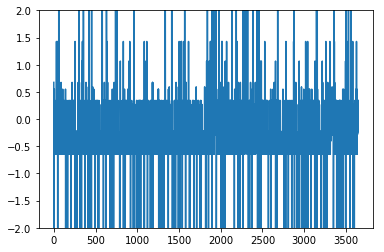

In [170]:
## Turing count for bigrams with upto 31 Nc

turing_count = {}
for i in bigrams:
    nc = bi_freq[i]
    if bi_freq[i] in range(2,31):
        turing_count[i] = (nc+1)*turing[nc+1]
        turing_count[i] =  turing_count[i]/turing[nc]

diff=[]
for i in turing_count:
    diff.append(turing_count[i]-bi_freq[i])

print ('Turing smooting for c=0 is %.4f'%(turing[1]/len(bigrams)))
print('d value (averaged) for turing smoothing is = %.3f'%(-1*sum(diff)/len(diff)))

plt.plot(range(len(diff)),diff)
plt.ylim(-2,2)
plt.show()

In [32]:
## Q7
### Doing for bigram models

mle_bi ={}

for i in uni_freq:
    mle_uni[i] = uni_freq[i]/tot_uni_count
for i in bi_freq:
    #print(i)
    uni = ('%s'%(i[1]),)
    #print(uni)
    mle_bi[i] = bi_freq[i]/uni_freq[uni]
for i in tri_freq:
    bi = ('%s'%(i[0]), '%s'%(i[1]))
    #print(bi)
    mle_tri[i] = tri_freq[i]/bi_freq[bi]

AttributeError: 'str' object has no attribute 'insert'

In [177]:
corpus

['‘would you like to see a little of it?’ said the mock turtle.',
 '‘i’m glad they don’t give birthday presents like that!’ but she did not venture to say it out loud.',
 'the duchess, the duchess!',
 'and the moral of that is--“birds of a feather flock together.”’  ‘only mustard isn’t a bird,’ alice remarked.',
 '‘beautiful soup!',
 '‘i can see you’re trying to invent something!’  ‘i--i’m a little girl,’ said alice, rather doubtfully, as she remembered the number of changes she had gone through that day.',
 'presently she began again.',
 'alice was silent.',
 'she is such a dear quiet thing,’ alice went on, half to herself, as she swam lazily about in the pool, ‘and she sits purring so nicely by the fire, licking her paws and washing her face--and she is such a nice soft thing to nurse--and she’s such a capital one for catching mice--oh, i beg your pardon!’ cried alice again, for this time the mouse was bristling all over, and she felt certain it must be really offended.',
 'the queen

In [6]:
## Below operation will give the total tokens
sum =0
for i in word_dict:
    sum += word_dict[i]

In [7]:
print('-----------------------------')
print('| Types |  Tokens  |  TTR   |') 
print('|  {0} |   {1}  | {2:0.4f} |'.format(len(word_dict),sum,len(word_dict)/sum))
print('-----------------------------')


-----------------------------
| Types |  Tokens  |  TTR   |
|  8421 |   88673  | 0.0950 |
-----------------------------


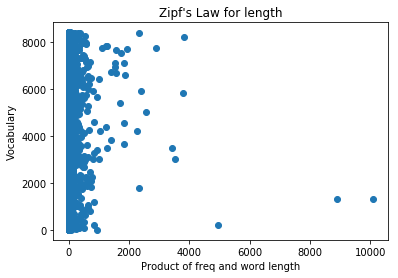

The Outliers are generally the most frequtely occuring word
Examles of them are
Word: , -- Freq: 4938
Word: and -- Freq: 2966
Word: the -- Freq: 3361
Word: you -- Freq: 780
Word: was -- Freq: 1174
Word: to -- Freq: 1718
Word: in -- Freq: 914
Word: it -- Freq: 1129
Word: he -- Freq: 924
Word: with -- Freq: 644
Word: 's -- Freq: 861
Word: . -- Freq: 3802
Word: Tom -- Freq: 805
Word: -- -- Freq: 929
Word: had -- Freq: 527
Word: ” -- Freq: 1527
Word: they -- Freq: 460
Word: “ -- Freq: 1534
Word: a -- Freq: 1751
Word: for -- Freq: 522
Word: n't -- Freq: 649
Word: of -- Freq: 1455
Word: that -- Freq: 960
Word: his -- Freq: 777


In [8]:
## To print the outliers
prod = []
outliers = []
for i in word_dict:
    if word_dict[i] ==1:
        pass
    prod.append(word_dict[i]*len(i))
    if word_dict[i]*len(i) > 1500:
        outliers.append(i)


## Plot for Zipf's law for Length.
## It should be a perfect straight line for zipfs law for length vs freq to be valid
plt.scatter(prod,range(len(prod)))
plt.title("Zipf's Law for length")
plt.xlabel('Product of freq and word length')
plt.ylabel('Vocabulary')
plt.show()

print('The Outliers are generally the most frequtely occuring word')
print('Examles of them are')
for i in outliers:
    print('Word: {0} -- Freq: {1}'.format(i,word_dict[i]))

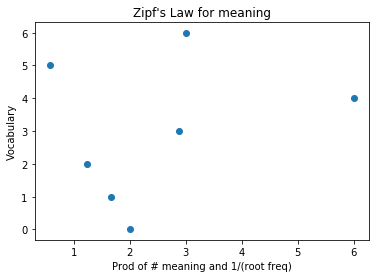

The plot should have been a horizontal line but as we can see 
it is not the case. This might be because the word vocabulary used for this is small 


In [9]:
## Number of meaning for a word 
meanings = {'wondered':2, 'lifts':3,'full':8,'fame':2,'familiar':3,'sunk':5,'cell':6}
mean_prod = []
for i in meanings:
    mean_prod.append(meanings[i]/(word_dict[i])**0.5)

## Potting the product of # meaning * (1/root freq) 
plt.scatter(mean_prod,range(len(mean_prod)))
plt.title("Zipf's Law for meaning")
plt.xlabel('Prod of # meaning and 1/(root freq)')
plt.ylabel('Vocabulary')
plt.show()
  
print('The plot should have been a horizontal line but as we can see \nit is not the case. This might be because the word vocabulary used for this is small ')

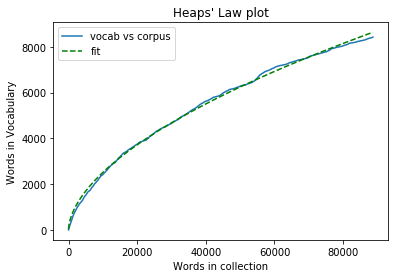

In [10]:
## Function created for Heaps' Law
def func(x,k,b):
    return k*(x**b)

## Curve Fitting to get the values of K and beta
popt, pcov = opt.curve_fit(func, token_size, vocabulary, bounds=(0.4,[100, 0.6]))
plt.plot(token_size,vocabulary,label = 'vocab vs corpus')
plt.plot(token_size, func(token_size, *popt), 'g--', label='fit')
plt.title("Heaps' Law plot")
plt.xlabel('Words in collection')
plt.ylabel('Words in Vocabulary')
plt.legend()
plt.show()

In [11]:
print ('Heaps law for this corpus:',end='')
print (' {0:0.3f}*(N^{1:0.3f})'.format(popt[0],popt[1]))

Heaps law for this corpus: 13.806*(N^0.565)


# References
1. Data downloading: https://stackoverflow.com/a/7244263
2. Curve fitting in scipy: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.curve_fit.html
3. Zipf's plot for meaning discussed with Arik Pamnani
4. https://stackoverflow.com/a/36798898/7630458 for freq distribution of n grams
5. https://stackoverflow.com/a/15555162/7630458 For regex tokenizer
6. https://courses.engr.illinois.edu/cs447/fa2017/Slides/Lecture04.pdf for add-1 smoothing